MAI643 - Artificial Intelligence in Medicine

Project Assignment 1 - Spring Semester 2024

Student Name:    
Christina Ioanna Saroglaki   
Jianlin Ye 

UCY Email:     
saroglaki.christina-ioanna@ucy.ac.cy    
jye00001@ucy.ac.cy 

This notebook use Structured Tabular Dataset # 1:
Cervical cancer dataset - http://archive.ics.uci.edu/ml/datasets/Cervical+cancer+%28Risk+Factors%29

### Import Libararies

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

import warnings

warnings.filterwarnings('ignore')

# Overview

As per the authors, the chosen dataset focuses on indicators associated with the diagnosis of cervical cancer, encompassing various features such as demographic information, habits, and medical records ​[3]​. In more detail, the data was gathered at 'Hospital Universitario de Caracas' in Venezuela from a total of 858 patients ​[3]​.

In [2]:
# Read the CSV file
risk_factor_df = pd.read_csv("/kaggle/input/mai643-risk-factors-cervical-cancer/risk_factors_cervical_cancer.csv")

# Display the updated DataFrame for .csv dataset
risk_factor_df.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
2,34,1.0,?,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,?,?,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,?,?,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,?,?,0,0,0,0,0,0,0,0


In [3]:
# Display the updated DataFrame for risk_factor.csv
risk_factor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 858 non-null    int64 
 1   Number of sexual partners           858 non-null    object
 2   First sexual intercourse            858 non-null    object
 3   Num of pregnancies                  858 non-null    object
 4   Smokes                              858 non-null    object
 5   Smokes (years)                      858 non-null    object
 6   Smokes (packs/year)                 858 non-null    object
 7   Hormonal Contraceptives             858 non-null    object
 8   Hormonal Contraceptives (years)     858 non-null    object
 9   IUD                                 858 non-null    object
 10  IUD (years)                         858 non-null    object
 11  STDs                                858 non-null    object

# Preprocessing

In [4]:
# Function for print the unique value of the dataframe
def print_unique_values_df(df: pd.DataFrame):
    for col in list(df):
        print("Unique Values for "'{}'":{}".format(str(col), risk_factor_df[col].unique()))
        print("dtype for {} :{}".format(str(col), risk_factor_df[col].dtypes))
        print("------------------------------------------------------------------------------")

# Function for print the unique value of the column
def print_unique_values_for_col(df: pd.DataFrame, col_names: List[str] = None):
    for col in col_names:
        print("Unique Values for "'{}'":{}".format(str(col), risk_factor_df[col].unique()))

Print the unique value of the dataframe

In [5]:
print_unique_values_df(risk_factor_df)

Unique Values for Age:[18 15 34 52 46 42 51 26 45 44 27 43 40 41 39 37 38 36 35 33 31 32 30 23
 28 29 20 25 21 24 22 48 19 17 16 14 59 79 84 47 13 70 50 49]
dtype for Age is :int64
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique Values for Number of sexual partners:['4.0' '1.0' '5.0' '3.0' '2.0' '6.0' '?' '7.0' '15.0' '8.0' '10.0' '28.0'
 '9.0']
dtype for Number of sexual partners is :object
------------------------------------------------------------------------------------------------------------------------------------------------------
Unique Values for First sexual intercourse:['15.0' '14.0' '?' '16.0' '21.0' '23.0' '17.0' '26.0' '20.0' '25.0' '18.0'
 '27.0' '19.0' '24.0' '32.0' '13.0' '29.0' '11.0' '12.0' '22.0' '28.0'
 '10.0']
dtype for First sexual intercourse is :object
----------------------------------------------------------------------------------------------------

In [6]:
#these columns are not of type object, but are of type numeric
# Rename the columns
cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']
# for i in range(0,len(cols_to_convert)):
#     print("{}={}".format(i,cols_to_convert[i]))
risk_factor_df[cols_to_convert] = risk_factor_df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
risk_factor_df[cols_to_convert].fillna(np.nan, inplace=True)
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(risk_factor_df)
risk_factor_df = pd.DataFrame(X, columns=list(risk_factor_df.columns))

In [7]:
# Convert the age to categories
def age_cat(age):
    if age < 12:
        return "Child"
    elif age < 20:
        return "Teen"
    elif age < 30:
        return "20's"
    elif age < 40:
        return "30's"
    elif age < 50:
        return "40's"
    elif age < 60:
        return "50's"
    elif age < 70:
        return "60's"
    else:
        return "70+"


risk_factor_df["Age"] = risk_factor_df["Age"].astype(int)
risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [8]:
# Define the std colmuns
std_cols = {'STDs:condylomatosis',
            'STDs:cervical condylomatosis',
            'STDs:vaginal condylomatosis',
            'STDs:vulvo-perineal condylomatosis',
            'STDs:syphilis',
            'STDs:pelvic inflammatory disease',
            'STDs:genital herpes',
            'STDs:molluscum contagiosum',
            'STDs:AIDS',
            'STDs:HIV',
            'STDs:Hepatitis B',
            'STDs:HPV'}

risk_factor_df["total_std"] = risk_factor_df[list(std_cols)].sum(axis=1)
std_agg = risk_factor_df.groupby("age_cat", as_index=False)[list(std_cols)].sum()

In [9]:
# Define the test columns
test_cols = ["Hinselmann", "Schiller", "Citology", "Biopsy"]
risk_factor_df["total_tests"] = risk_factor_df[test_cols].sum(axis = 1)

In [10]:
to_int_and_beyond = {"total_tests",
                     "total_std",
                     "Smokes",
                     "Biopsy",
                     "Dx:Cancer",
                     "Num of pregnancies",
                     "Number of sexual partners",
                     "First sexual intercourse",
                     "Hormonal Contraceptives",
                     "IUD",
                     "STDs",
                     "STDs (number)",
                     "STDs: Number of diagnosis",
                     "Dx:CIN",
                     "Dx:HPV",
                     "Dx",
                     "Hinselmann",
                     "Schiller",
                     "Biopsy",
                     "Citology"}

to_int_and_beyond = to_int_and_beyond.union(std_cols)

for col in to_int_and_beyond:
    risk_factor_df[col] = risk_factor_df[col].astype(int)

In [11]:
# Display the dataframe again
risk_factor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           858 non-null    int64  
 2   First sexual intercourse            858 non-null    int64  
 3   Num of pregnancies                  858 non-null    int64  
 4   Smokes                              858 non-null    int64  
 5   Smokes (years)                      858 non-null    float64
 6   Smokes (packs/year)                 858 non-null    float64
 7   Hormonal Contraceptives             858 non-null    int64  
 8   Hormonal Contraceptives (years)     858 non-null    float64
 9   IUD                                 858 non-null    int64  
 10  IUD (years)                         858 non-null    float64
 11  STDs                                858 non-n

In [12]:
# corr_matrix = risk_factor_df.corr()
# corr_matrix.fillna(0,inplace=True)
# corr_graph = px.imshow(corr_matrix, aspect="auto")
# corr_graph.show()

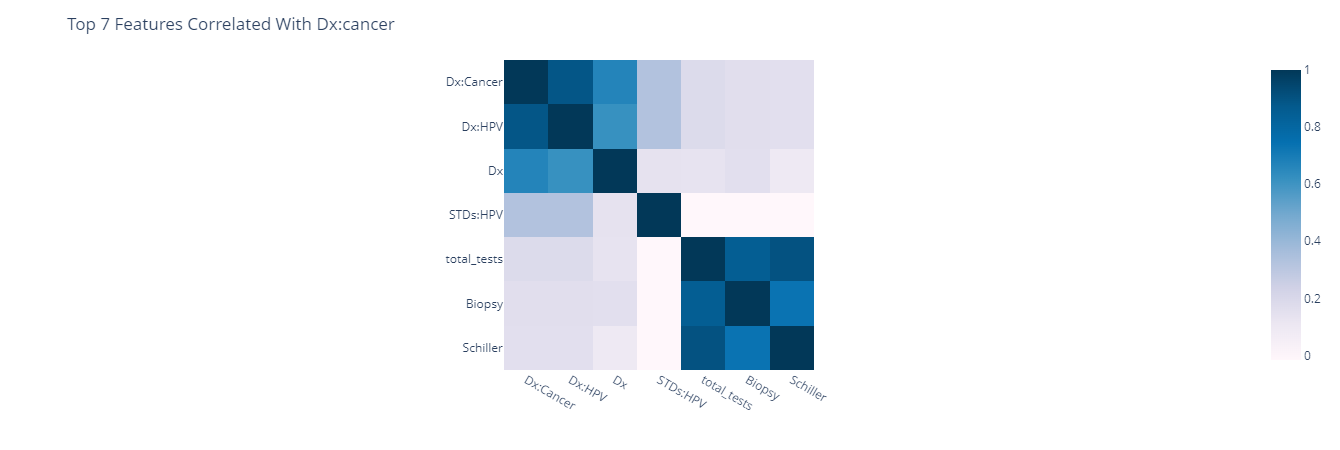

In [13]:
n = 7
target = "Dx:Cancer"
corr = risk_factor_df.select_dtypes(include=np.number).corr()

x = corr.nlargest(n,target).index
corr_df =  risk_factor_df[list(x)]
corr = corr_df.corr()
fig = px.imshow(corr,color_continuous_scale = "PuBu")
fig.update_layout(title="Top "+str(n)+" Features Correlated With "+str(target).capitalize())
fig.show()

# Visualization

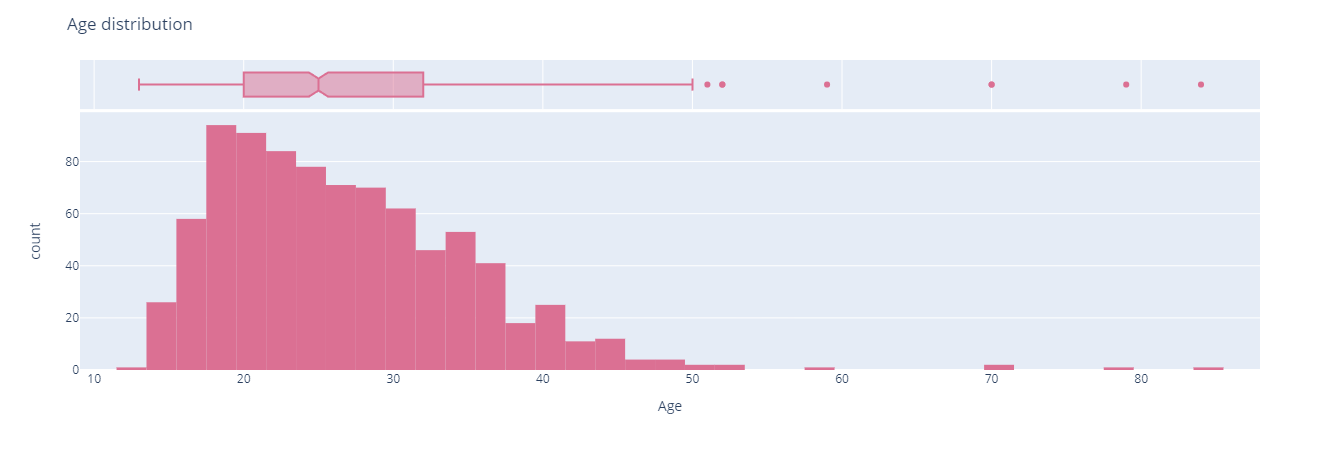

In [14]:
age_dist = px.histogram(risk_factor_df, x="Age", marginal="box", color_discrete_sequence=["palevioletred"])
age_dist.update_layout(title="Age distribution")
age_dist.show()

## Pregnancy Distribution by Age

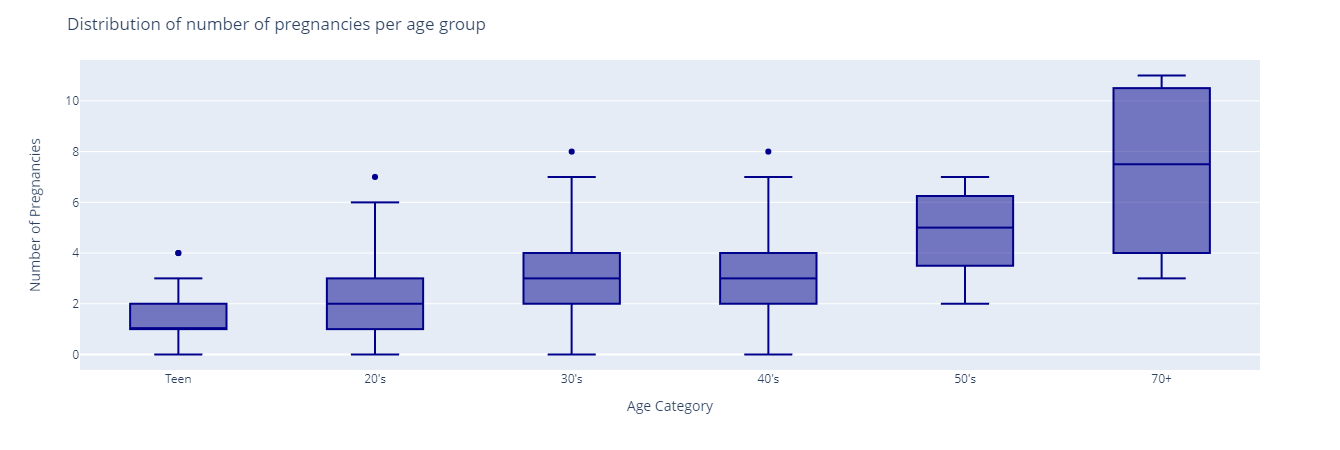

In [15]:
age_preg_bar = px.box(risk_factor_df.sort_values(by="Age",ascending=True), x="age_cat", y="Num of pregnancies",
                      color_discrete_sequence=["darkblue"], points="outliers",
                      category_orders=["Teenager", "Twenties", "Thirties", "Forties", "Fifties",
                                       "Seventy and over"])
age_preg_bar.update_xaxes(title="Age Category")
age_preg_bar.update_yaxes(title="Number of Pregnancies")
age_preg_bar.update_layout(title="Distribution of number of pregnancies per age group")
age_preg_bar.show()

## Risk factors for cervical cancer include:


* Many sexual partners. The greater your number of sexual partners — and the greater your partner's number of sexual partners — the greater your chance of acquiring HPV.
* Early sexual activity. Having sex at an early age increases your risk of HPV.
* Other sexually transmitted infections (STIs). Having other STIs — such as chlamydia, gonorrhea, syphilis and HIV/AIDS — increases your risk of HPV.
* A weakened immune system. You may be more likely to develop cervical cancer if your immune system is weakened by another health condition and you have HPV.
* Smoking. Smoking is associated with squamous cell cervical cancer.
* Exposure to miscarriage prevention drug. If your mother took a drug called diethylstilbestrol (DES) while pregnant in the 1950s, you may have an increased risk of a certain type of cervical cancer called clear cell adenocarcinoma.

   [Reference](https://www.mayoclinic.org/diseases-conditions/cervical-cancer/symptoms-causes/syc-20352501#:~:text=Cervical%20cancer%20is%20a%20type,in%20causing%20most%20cervical%20cancer.)

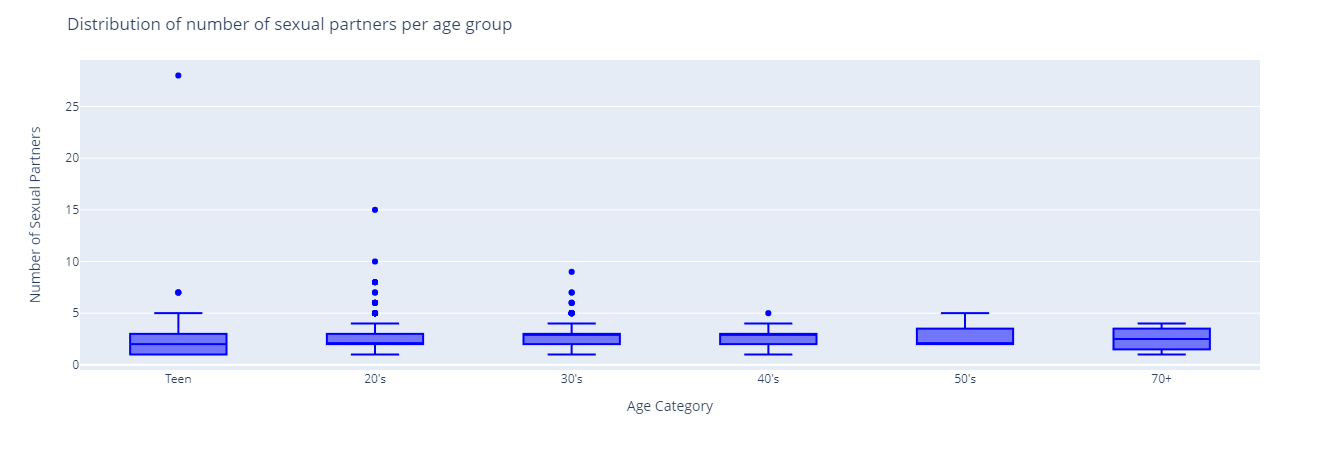

In [16]:
age_num_sex_partners = px.box(risk_factor_df.sort_values(by="Age",ascending=True), x="age_cat", y="Number of sexual partners",
                      color_discrete_sequence=["blue"], points="outliers",
                      category_orders=["Teenager", "Twenties", "Thirties", "Forties", "Fifties",
                                       "Seventy and over"])
age_num_sex_partners.update_xaxes(title="Age Category")
age_num_sex_partners.update_yaxes(title="Number of Sexual Partners")
age_num_sex_partners.update_layout(title="Distribution of number of sexual partners per age group")
age_num_sex_partners.show()

From the scatterplot, it is seen that the number of sexual partners have remained consistent throught out differing age ranges.

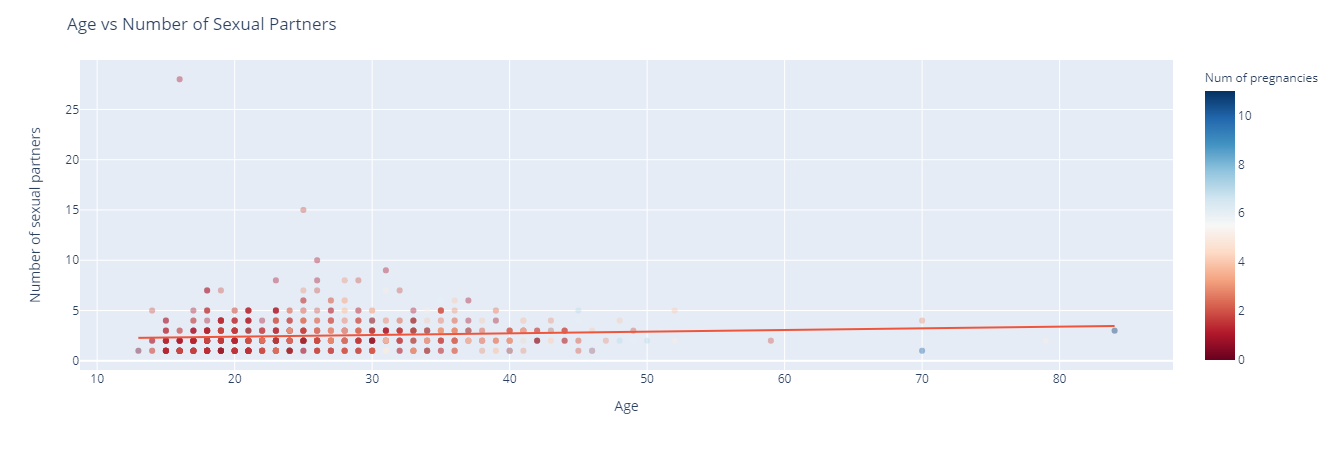

In [17]:
age_num_sex_partners = px.scatter(risk_factor_df, x="Age",
                                  y="Number of sexual partners",
                                  trendline="ols",
                                  opacity=0.4,
                                  color="Num of pregnancies",
                                  color_continuous_scale="rdbu",)
age_num_sex_partners.update_layout(title="Age vs Number of Sexual Partners")
age_num_sex_partners.show()

From the heatmap, we can see that there a correlation coefficent very close to 0, this indicates that, from the data, the number of sexual partners does not have any linear relationship with any of the respective diagnoses. However, we also visually knew that the number of sexual partners remained fairly consistent across age ranges and therefore there are more likely causes of HPV and Cervical Cancer than number of sexual partners with respect to the data.

                           Dx:Cancer    Dx:HPV  Number of sexual partners
Dx:Cancer                   1.000000  0.886508                   0.023699
Dx:HPV                      0.886508  1.000000                   0.028646
Number of sexual partners   0.023699  0.028646                   1.000000


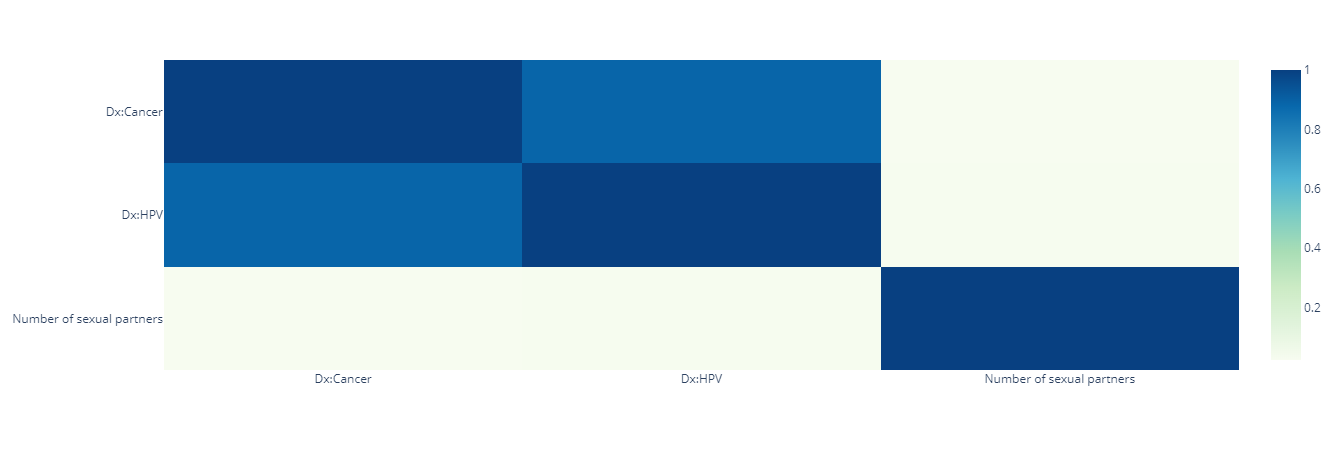

In [18]:
diagnoses_num_partner_compare_cols = ['Dx:Cancer',
                                      'Dx:HPV',
                                      "Number of sexual partners",]
corr_matrix = risk_factor_df[diagnoses_num_partner_compare_cols].corr()
print(corr_matrix)
diagnoses_num_partner_heatmap = px.imshow(corr_matrix,
                              aspect="auto",
                              color_continuous_scale="gnbu",
                              text_auto=True)
diagnoses_num_partner_heatmap.show()

## Correlation of diagnoses

Comparing the diagnoses, to see if there is any correlation among them. It's seen that a HPV diagnosis and Cervical Cancer Diagnosis have a correlation of approximately +0.89, this is indicative of a strong positive correlation. In some regard, it can be interprted as a diagnosis of HPV is likely to lead to a diagnosis of Cervical Cancer.

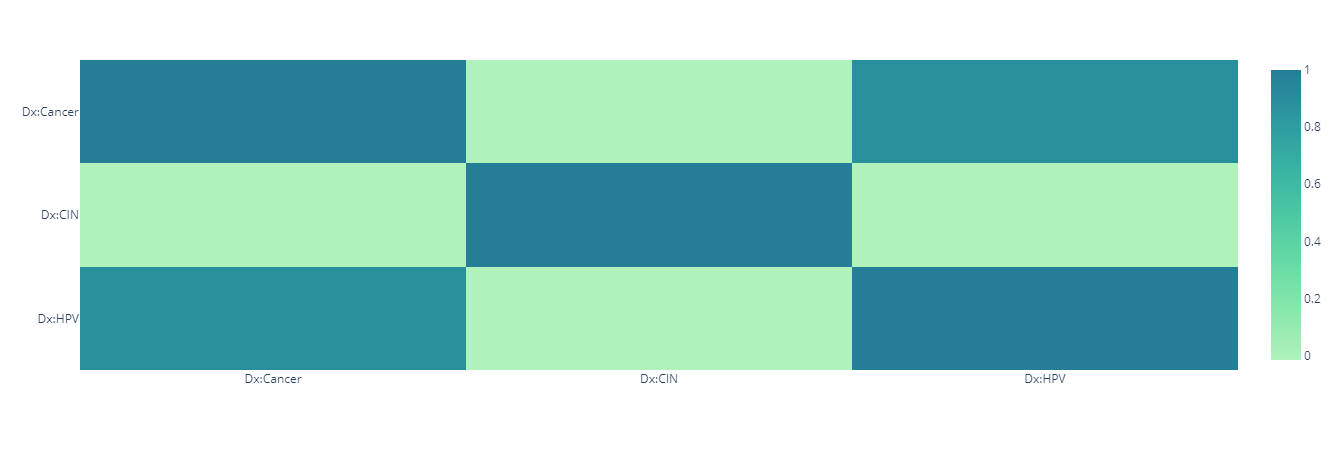

In [19]:
diagnoses_cols = ['Dx:Cancer',
                  'Dx:CIN',
                  'Dx:HPV']
diagnoses_corr_matrix = risk_factor_df[diagnoses_cols].corr()
# print(diagnoses_corr_matrix)
diagnoses_heatmap = px.imshow(diagnoses_corr_matrix, aspect="auto", color_continuous_scale="tealgrn", text_auto=True)
diagnoses_heatmap.show()

## STD's Definitions

### Syphilis

Syphillis is a bacterial infection usually spread by sexual contact. The disease starts as a painless sore — typically on the genitals, rectum or mouth. Syphilis spreads from person to person via skin or mucous membrane contact with these sores.After the initial infection, the syphilis bacteria can remain inactive in the body for decades before becoming active again. Early syphilis can be cured, sometimes with a single shot (injection) of penicillin.Without treatment, syphilis can severely damage the heart, brain or other organs, and can be life-threatening. Syphilis can also be passed from mothers to unborn children. [Source](https://www.mayoclinic.org/diseases-conditions/syphilis/symptoms-causes/syc-20351756#:~:text=Syphilis%20is%20a,to%20unborn%20children.)

### HIV/AIDS

HIV (human immunodeficiency virus) is a virus that attacks cells that help the body fight infection, making a person more vulnerable to other infections and diseases. It is spread by contact with certain bodily fluids of a person with HIV, most commonly during unprotected sex (sex without a condom or HIV medicine to prevent or treat HIV), or through sharing injection drug equipment. *If left untreated, HIV can lead to the disease AIDS (acquired immunodeficiency syndrome* [Source](https://www.hiv.gov/hiv-basics/overview/about-hiv-and-aids/what-are-hiv-and-aids#:~:text=HIV%20(human,acquired%20immunodeficiency%20syndrome)

### Cervical / Vaginal Condylomatosis

Condyloma or genital warts affect the tissues of the genital area due to infections induced by Human papillomavirus. [Source](https://pubmed.ncbi.nlm.nih.gov/32389737/#:~:text=Condyloma%20or%20genital%20warts%20affect%20the%20tissues%20of%20the%20genital%20area%20due%20to%20infections%20induced%20by%20Human%20papillomavirus.)

### Vulvo-perineal condylomatosis
It is a benign epithelial proliferative viral lesion that can affect any area of the vulvo-perineal district supported by human papilloma virus (HPV). [Source](https://www.lriog.it/en/condilomatosi-vulvare/#:~:text=It%20is%20a%20benign%20epithelial%20proliferative%20viral%20lesion%20that%20can%20affect%20any%20area%20of%20the%20vulvo%2Dperineal%20district%20supported%20by%20human%20papilloma%20virus%20(HPV).)

### Genital Herpes

Genital herpes is a common sexually transmitted infection caused by the herpes simplex virus (HSV). Sexual contact is the primary way that the virus spreads. After the initial infection, the virus lies dormant in your body and can reactivate several times a year.
Genital herpes can cause pain, itching and sores in your genital area. But you may have no signs or symptoms of genital herpes. If infected, you can be contagious even if you have no visible sores.There's no cure for genital herpes, but medications can ease symptoms and reduce the risk of infecting others. Condoms also can help prevent the spread of a genital herpes infection. [Source](https://www.mayoclinic.org/diseases-conditions/genital-herpes/symptoms-causes/syc-20356161#:~:text=Genital%20herpes%20is,genital%20herpes%20infection.)

### HPV
HPV infection is a viral infection that commonly causes skin or mucous membrane growths (warts). There are more than 100 varieties of human papillomavirus (HPV). Some types of HPV infection cause warts, and some can cause different types of cancer.
Most HPV infections don't lead to cancer. But some types of genital HPV can cause cancer of the lower part of the uterus that connects to the vagina (cervix). Other types of cancers, including cancers of the anus, penis, vagina, vulva and back of the throat (oropharyngeal), have been linked to HPV infection.
These infections are often transmitted sexually or through other skin-to-skin contact. Vaccines can help protect against the strains of HPV most likely to cause genital warts or cervical cancer. [Source](https://www.mayoclinic.org/diseases-conditions/hpv-infection/symptoms-causes/syc-20351596#:~:text=HPV%20infection%20is,or%20cervical%20cancer.)

### Molluscum Contagisum 

Molluscum contagiosum is an infection caused by a poxvirus (molluscum contagiosum virus). The result of the infection is usually a benign, mild skin disease characterized by lesions (growths) that may appear anywhere on the body. Within 6-12 months, Molluscum contagiosum typically resolves without scarring but may take as long as 4 years.
The lesions, known as Mollusca, are small, raised, and usually white, pink, or flesh-colored with a dimple or pit in the center. They often have a pearly appearance. They’re usually smooth and firm. In most people, the lesions range from about the size of a pinhead to as large as a pencil eraser (2 to 5 millimeters in diameter). They may become itchy, sore, red, and/or swollen.
Mollusca may occur anywhere on the body including the face, neck, arms, legs, abdomen, and genital area, alone or in groups. The lesions are rarely found on the palms of the hands or the soles of the feet. [Source](https://www.cdc.gov/poxvirus/molluscum-contagiosum/index.html#:~:text=Molluscum%20contagiosum%20is,of%20the%20feet.)

The virus that causes molluscum spreads from direct person-to-person physical contact and through contaminated fomites. Fomites are inanimate objects that can become contaminated with virus; in the instance of molluscum contagiosum this can include linens such as clothing and towels, bathing sponges, pool equipment, and toys [Source](https://www.cdc.gov/poxvirus/molluscum-contagiosum/transmission.html#:~:text=The%20virus%20that,equipment%2C%20and%20toys)

Someone with molluscum can spread it to other parts of their body by touching or scratching a lesion and then touching their body somewhere else. This is called autoinoculation. Shaving and electrolysis can also spread mollusca to other parts of the body. *Molluscum can spread from one person to another by sexual contact. Many, but not all, cases of molluscum in adults are caused by sexual contact.* [Source](https://www.cdc.gov/poxvirus/molluscum-contagiosum/transmission.html#:~:text=Someone%20with%20molluscum%20can,caused%20by%20sexual%20contact.)

### Hepatitis B

Hepatitis B is a vaccine-preventable liver infection caused by the hepatitis B virus (HBV). Hepatitis B is spread when blood, semen, or other body fluids from a person infected with the virus enters the body of someone who is not infected. This can happen through sexual contact; sharing needles, syringes, or other drug-injection equipment; or from mother to baby at birth. [**Source**](https://www.cdc.gov/hepatitis/hbv/index.htm#:~:text=Hepatitis%20B%20is,baby%20at%20birth.)

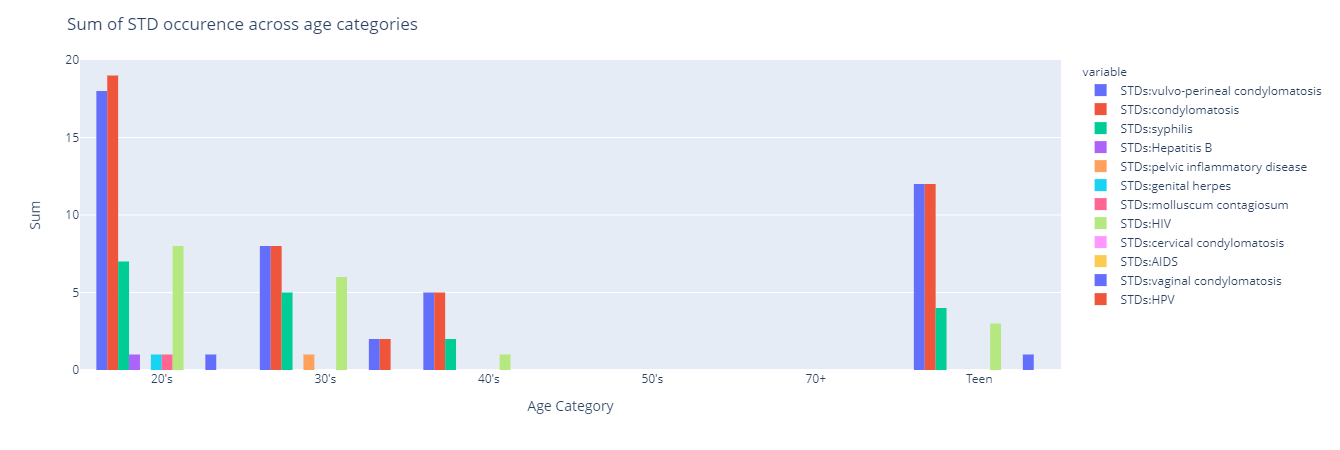

In [20]:
fig = px.histogram(std_agg, x="age_cat", y=list(std_cols), barmode="group", histfunc="sum")
fig.update_layout(title="Sum of STD occurence across age categories")
fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Sum")
fig.show()

We see that the most amount of STD's garnered by any patient, is a total of 4. As from before, we also see that the majority of patients do not have any STD's and aren't diagnosed with cancer and/or HPV. However, there is a small amount of patients who have no STD and have Cervical Cancer and/or HPV. *It should be noted that HPV infections can be sexually transmitted or non-sexually acquired.*

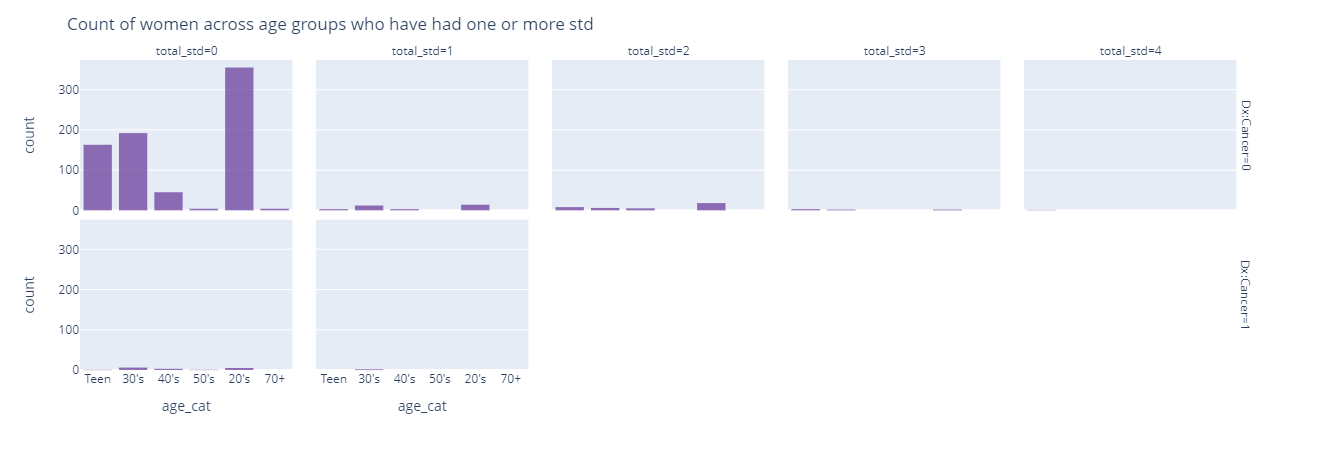

In [21]:
fig = px.histogram(risk_factor_df.query("total_std>=0").sort_values(by=["total_std", "Dx:Cancer"], ascending=True),
                   x="age_cat",
                   facet_col="total_std",
                   facet_row="Dx:Cancer",
                   color_discrete_sequence=["rebeccapurple"],
                   opacity=0.7)
fig.update_layout(title="Count of women across age groups who have had one or more std")

fig.show()

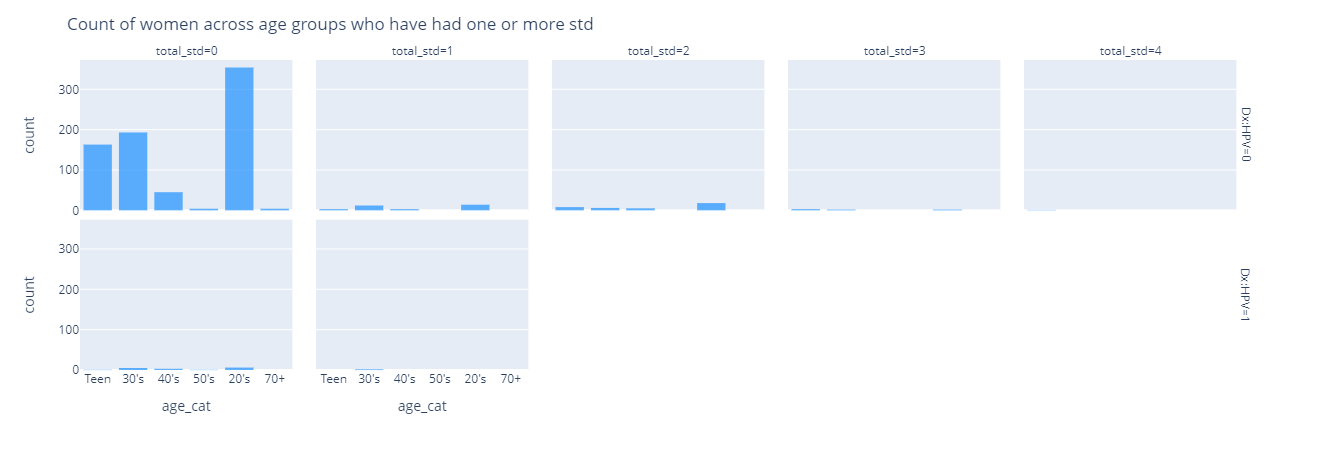

In [22]:
fig = px.histogram(risk_factor_df.query("total_std>=0").sort_values(by=["total_std","Dx:HPV"], ascending=True),
                   x="age_cat",
                   facet_col="total_std",
                   facet_row="Dx:HPV",
                   color_discrete_sequence=["dodgerblue"],
                   opacity=0.7)
fig.update_layout(title="Count of women across age groups who have had one or more std")

fig.show()

## Tests used 
Here we observe the number of tests done by patients to determine if they have Cerivcal Cancer / HPV.

The tests used were: 

### Hinselmann

A colposcopy is a type of cervical cancer test. It lets your doctor or nurse get a close-up look at your cervix — the opening to your uterus. It’s used to find abnormal cells in your cervix. [Source](https://www.plannedparenthood.org/learn/cancer/cervical-cancer/what-colposcopy)

### Citology
Cytology is the exam of a single cell type, as often found in fluid specimens. It's mainly used to diagnose or screen for cancer. It's also used to screen for fetal abnormalities, for pap smears, to diagnose infectious organisms, and in other screening and diagnostic areas. [Source](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/cytology#:~:text=Cytology%20is%20the%20exam%20of,other%20screening%20and%20diagnostic%20areas.)
### Biopsy
A cervical biopsy is a procedure to remove tissue from the cervix to test for abnormal or precancerous conditions, or cervical cancer. [Source](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/cervical-biopsy#:~:text=What%20is%20a%20cervical%20biopsy,that%20opens%20into%20the%20vagina.)
### Schiller
A test in which iodine is applied to the cervix. The iodine colors healthy cells brown; abnormal cells remain unstained, usually appearing white or yellow. [Source](https://www.cancer.gov/publications/dictionaries/cancer-terms/def/schiller-test)


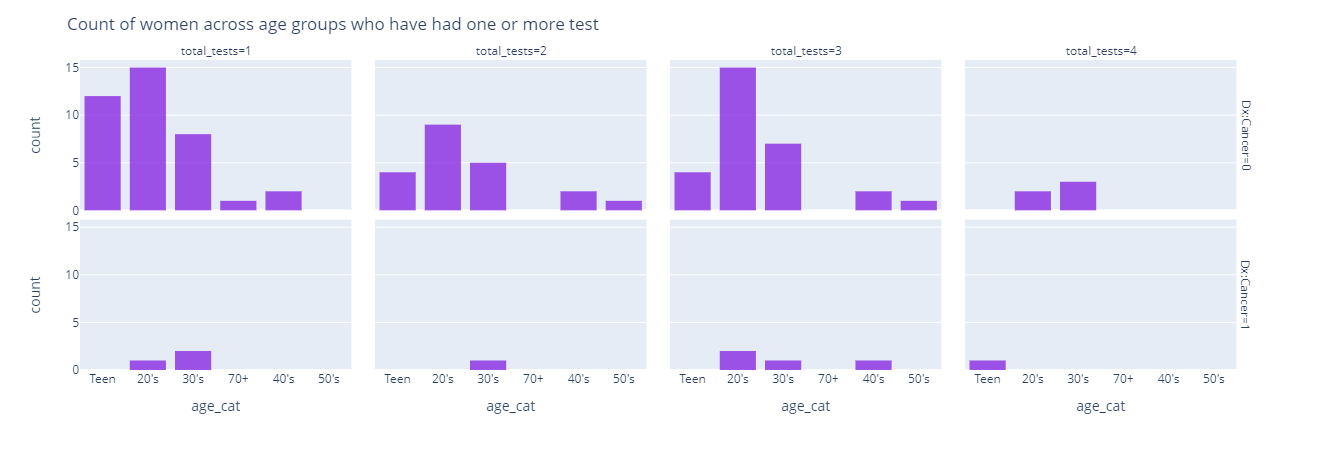

In [23]:
fig = px.histogram(risk_factor_df.query("total_tests>0").sort_values(by="total_tests", ascending=True),
                   x="age_cat",
                   facet_col="total_tests",
                   facet_row="Dx:Cancer",
                   color_discrete_sequence=["blueviolet"],
                   opacity=0.8)
fig.update_layout(title="Count of women across age groups who have had one or more test")

fig.show()

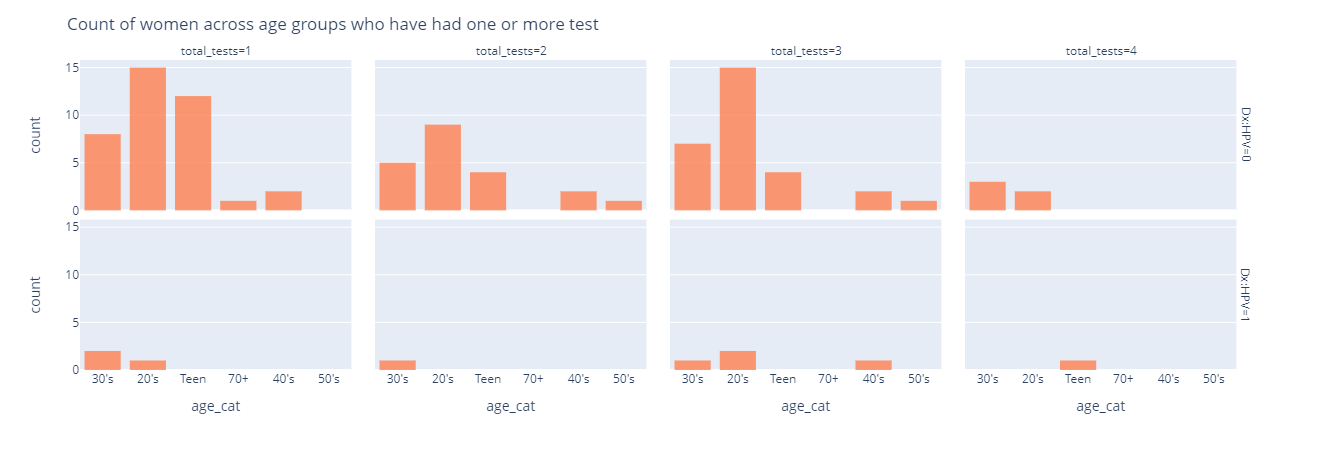

In [24]:
fig = px.histogram(risk_factor_df.query("total_tests>0").sort_values(by=["total_tests","Dx:HPV"], ascending=True),
                   x="age_cat",
                   facet_col="total_tests",
                   facet_row="Dx:HPV",
                   color_discrete_sequence=["coral"],
                   opacity=0.8)
fig.update_layout(title="Count of women across age groups who have had one or more test")

fig.show()

We see from the ECDF plot, that:

* There is roughly a 95% probability that patients have smoked for less than 10 years
* There is roughly a 99% probability that patients have used IUD's for less than 10 years
* There is roughly a 99% probabilty that patients have used Hormonal Contraceptives for less than 10 years

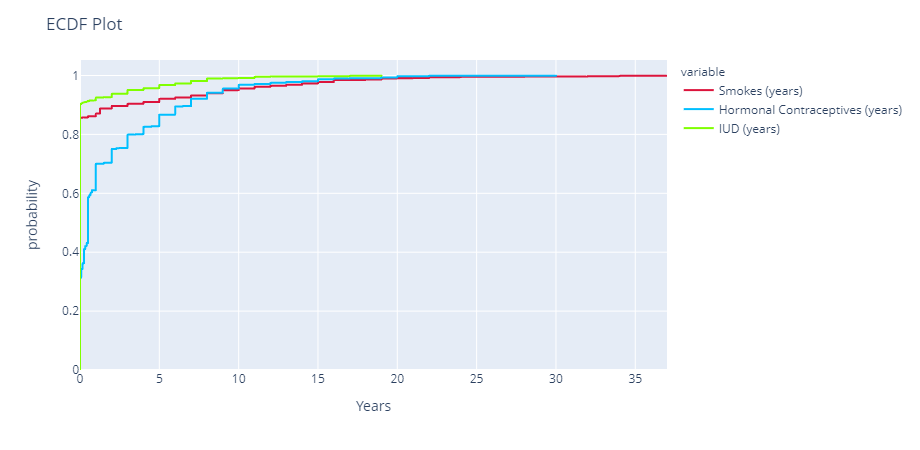

In [25]:
fig = px.ecdf(risk_factor_df, x=["Smokes (years)",
                                 "Hormonal Contraceptives (years)",
                                 "IUD (years)"],
              color_discrete_sequence=["crimson", "deepskyblue", "chartreuse"])
fig.update_xaxes(title="Years")
fig.update_layout(title="ECDF Plot")
fig.show()

## Proportions of women who have Cervical Cancer / HPV

This represents the proportion of women by age category who were diagnosed with Cervical Cancer/ HPV. It is seen that women in their 30's have the most prevalance of Cervical Cancer and HPV, followed by women in their 20's.

It is also seen that of all the samples taken, approximately 26% are of women in their 30's. With respect to the women who have cervical cancer, approximately 44% of cases are women in their 30's, also, out of the women who have HPV, approximately 39% of women are in their 30's. This is contrasted with 45% of all samples being women in their 20's and only 28% of the women have cancer are in their 20's, HPV is more comparable at 33%.

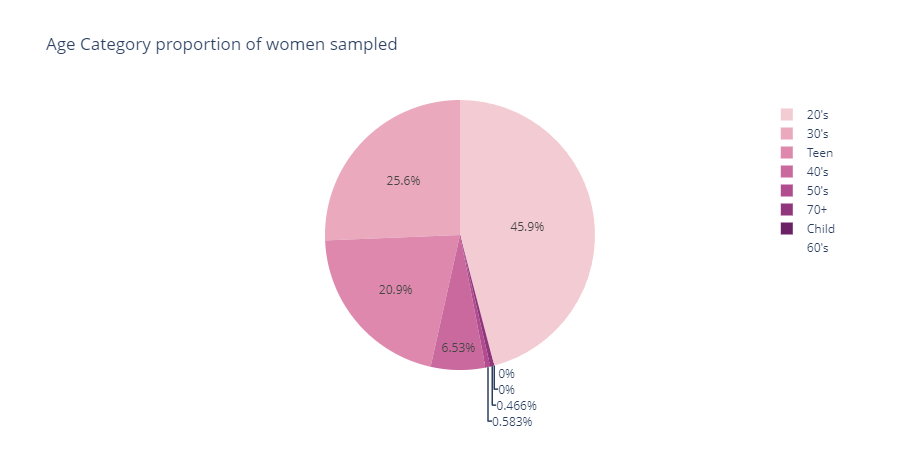

,Category,Sample Proportion
0,Child,0.000000
1,Teen,0.208625
2,20's,0.459207
3,30's,0.256410
4,40's,0.065268
5,50's,0.005828
6,60's,0.000000
7,70+,0.004662


In [26]:
age_category_range = {
    "Age<12": "Child",
    "Age>=12 & Age<20": "Teen",
    "Age>=20 & Age<30": "20's",
    "Age>=30 & Age<40": "30's",
    "Age>=40 & Age<50": "40's",
    "Age>=50 & Age<60": "50's",
    "Age>=60 & Age<70": "60's",
    "Age>=70": "70+"}
age_prop_dict = {}
col = "Age"  # Just to get the count
for age_range, category in age_category_range.items():
    age_prop_dict[category] = risk_factor_df.query(age_range)[col].count() / len(risk_factor_df)

proportion_samples_df = pd.DataFrame.from_dict(age_prop_dict, orient="index",
                                               columns=[ "Sample Proportion"])
proportion_samples_df = proportion_samples_df.reset_index()
proportion_samples_df.columns = proportion_samples_df.columns.str.replace("index","Category")
fig = px.pie(proportion_samples_df,
             values='Sample Proportion',
             names="Category",
             title='Age Category proportion of women sampled',color_discrete_sequence=px.colors.sequential.Magenta)
fig.show()
proportion_samples_df

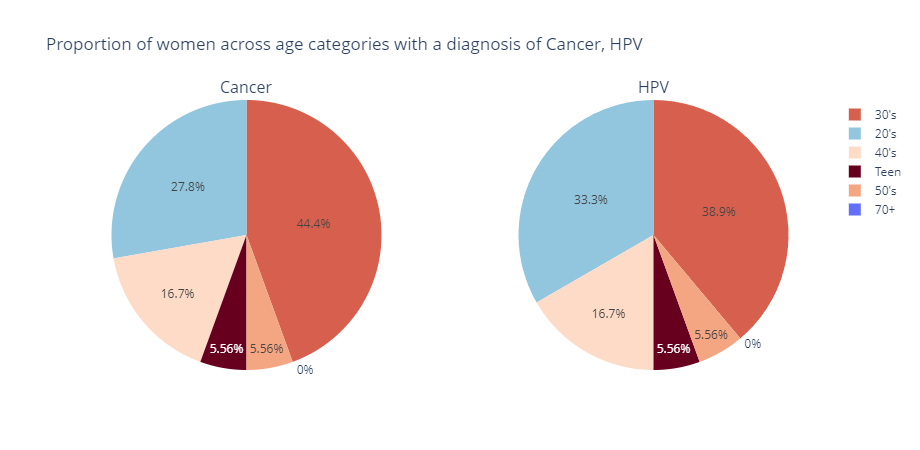

In [27]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type': 'domain'}, {'type': 'domain'}]],
                    subplot_titles=["Cancer", "HPV"])
fig.add_trace(go.Pie(labels=risk_factor_df["age_cat"],
                     values=risk_factor_df["Dx:Cancer"],
                     name="Cancer", marker_colors=px.colors.sequential.RdBu),
              1, 1)
fig.add_trace(go.Pie(labels=risk_factor_df["age_cat"],
                     values=risk_factor_df["Dx:HPV"],
                     name="HPV", marker_colors=px.colors.sequential.RdBu),
              1, 2)

fig.update_traces(hole=.0, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Proportion of women across age categories with a diagnosis of Cancer, HPV",
)
fig.show()


## Contraceptive Overview
### IUD 
IUD stands for Intrauterine Device (basically: a device inside your uterus). It's a small piece of flexible plastic shaped like a T. Sometimes it’s called an IUC — intrauterine contraception. Can cost up to $1,300.00 USD

IUDs are divided into 2 types:

* Hormonal IUDs 
* Copper IUDs 

Both copper IUDs and hormonal IUDs prevent pregnancy by changing the way sperm cells move so they can't get to an egg. If sperm can’t make it to an egg, pregnancy can’t happen. [Source](https://www.plannedparenthood.org/learn/birth-control/iud)

### Hormonal Contraceptive 

* The birth control pill works by stopping sperm from joining with an egg. When sperm joins with an egg it’s called fertilization.

* The hormones in the pill safely stop ovulation. No ovulation means there’s no egg for sperm to fertilize, so pregnancy can’t happen.

* The pill’s hormones also thicken the mucus on the cervix. This thicker cervical mucus blocks sperm so it can’t swim to an egg — kind of like a sticky security guard.

* Can cost up to $50.00 USD. [Source](https://www.plannedparenthood.org/learn/birth-control/birth-control-pill)

## Hormonal Contraceptives and Cervical Cancer

Women who have used oral contraceptives for 5 or more years have a higher risk of cervical cancer than women who have never used oral contraceptives. The longer a woman uses oral contraceptives, the greater the increase in her risk of cervical cancer. One study found a 10% increased risk for less than 5 years of use, a 60% increased risk with 5–9 years of use, and a doubling of the risk with 10 or more years of use. However, the risk of cervical cancer has been found to decline over time after women stop using oral contraceptives. [Source](https://www.cancer.gov/about-cancer/causes-prevention/risk/hormones/oral-contraceptives-fact-sheet#r12:~:text=Women%20who%20have%20used,stop%20using%20oral%20contraceptives%20()

The usage of hormonal contraceptives is significantly higher than the usage of IUD's, this can most likely be attributed to it's low cost and easy accessibility

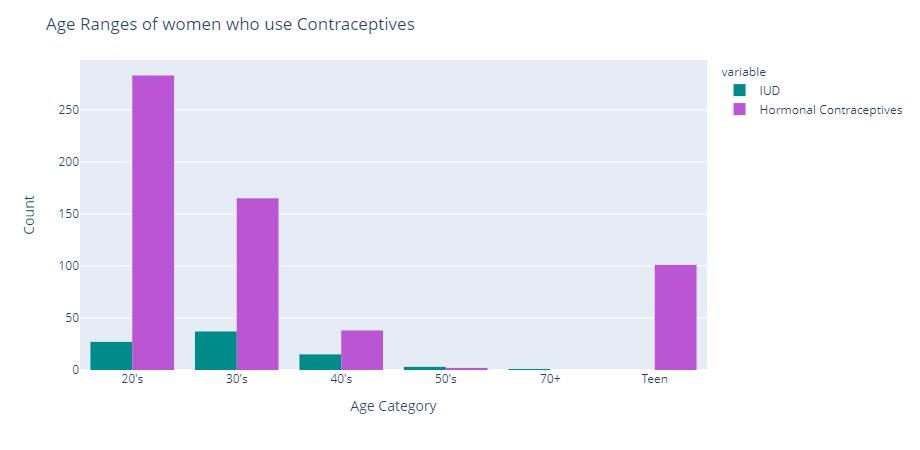

In [28]:
df_hormonal_compariosn = risk_factor_df.groupby(["age_cat"], as_index=False)[["IUD", "Hormonal Contraceptives"]].sum()
fig = px.histogram(df_hormonal_compariosn, x="age_cat", y=["IUD", "Hormonal Contraceptives"], barmode="group"
                   , color_discrete_sequence=["darkcyan", "mediumorchid"])

fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Count")
fig.update_layout(title="Age Ranges of women who use Contraceptives")

fig.show()

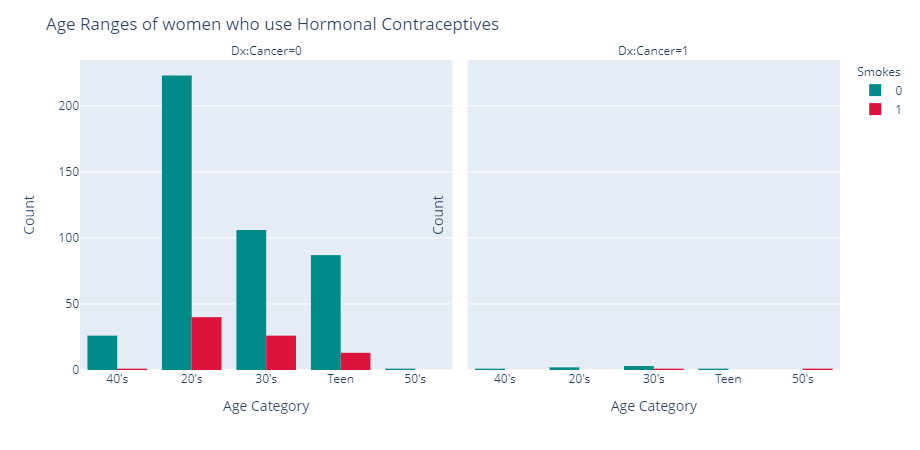

In [29]:
df_hormonal_contraceptives = risk_factor_df[
    (risk_factor_df["Hormonal Contraceptives"] == 1) & (risk_factor_df["IUD"] == 0)]
df_hormonal_contraceptives = df_hormonal_contraceptives.sort_values(by=["Smokes", "Dx:Cancer"])
fig = px.histogram(df_hormonal_contraceptives, x="age_cat", color="Smokes", barmode="group", facet_col="Dx:Cancer",
                   color_discrete_sequence=["darkcyan", "crimson"])
fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Count")
fig.update_layout(title="Age Ranges of women who use Hormonal Contraceptives")
# fig.for_each_annotation(lambda a: a.update(text=a.text.split(":")[-1]))
fig.show()

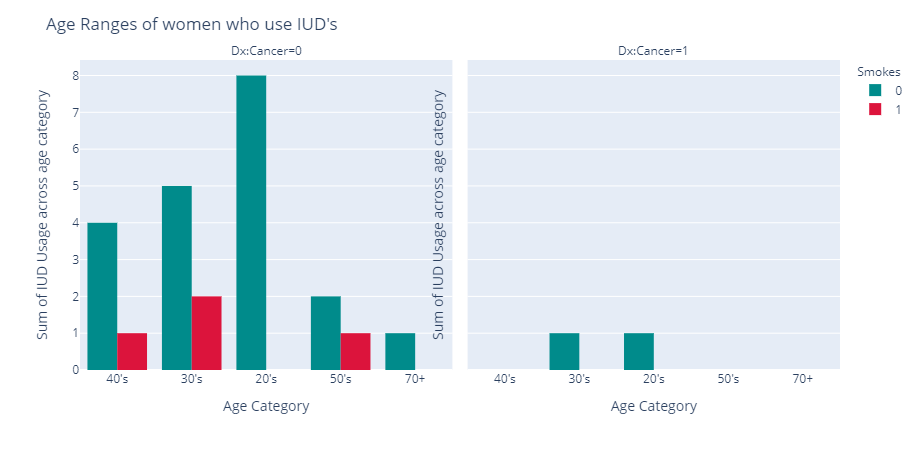

In [30]:
df_IUD_contraceptives = risk_factor_df[(risk_factor_df["Hormonal Contraceptives"] == 0) & (risk_factor_df["IUD"] == 1)]
df_IUD_contraceptives = df_IUD_contraceptives.sort_values(by=["Smokes", "Dx:Cancer"], ascending=True)
fig = px.histogram(df_IUD_contraceptives, x="age_cat", color="Smokes", barmode="group", facet_col="Dx:Cancer",
                   color_discrete_sequence=["darkcyan", "crimson"])
fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Sum of IUD Usage across age category")
fig.update_layout(title="Age Ranges of women who use IUD's")
fig.show()

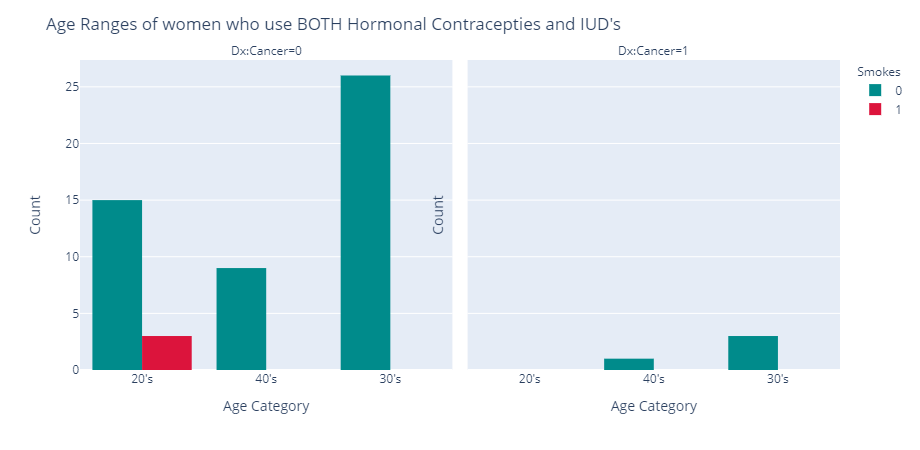

In [31]:
df_both_contraceptives = risk_factor_df[(risk_factor_df["Hormonal Contraceptives"] == 1) & (risk_factor_df["IUD"] == 1)]
df_both_contraceptives = df_both_contraceptives.sort_values(by="Smokes")
fig = px.histogram(df_both_contraceptives, x="age_cat", color="Smokes", barmode="group", facet_col="Dx:Cancer",
                   color_discrete_sequence=["darkcyan", "crimson"])
fig.update_xaxes(title="Age Category")
fig.update_yaxes(title="Count")
fig.update_layout(title="Age Ranges of women who use BOTH Hormonal Contracepties and IUD's")
fig.show()

# Imbalanced Class
The "Dx:Cancer" class is an imbalanced class with just 18 classified as cancer and 840 as not cancer. This roughly translates to 2.1% classified as cancer and 97.9 % classified as not cancer.

There are two main apporaches for dealing with imbalanced classes:
* Undersampling
* Oversampling

## Undersampling
* Random Undersampling
* Tomek links for under sampling
* Near miss

Undersampling techniques weren't considered as this would lead to a significant loss of information and underperforms against oversampling.

## Oversampling
The techniques I considered for balancing these classes are: 
* Synthetic Minority Oversampling Technique (SMOTE)
* Adaptive synthetic sampling ( ADASYN)
* Random Oversampling 

### Random Oversampling
The main issue with this method of class balancing is that it repeats the same minority class, this in turn can lead to overfitting of the data. 

### SMOTE
This method creates "synthetic" samples rather than replication of instances, as such this alleviates the issue of overfitting and there is no loss of information.
However, an issue with SMOTE is that it does not take into consideration samples from neighboring classes, this can possibly result in the overlap of classes. 

### ADASYN
This method also creates "synthetic data, however it does not generate points form nearby points as SMOTE does, instead it uses outlier points to generate new points of data. Essentially, it generates differing number of samples depending on an estimate of the local distribution of the class to to be oversampled. As with SMOTE, this allevaites the issue of overfitting and there is no information lost.

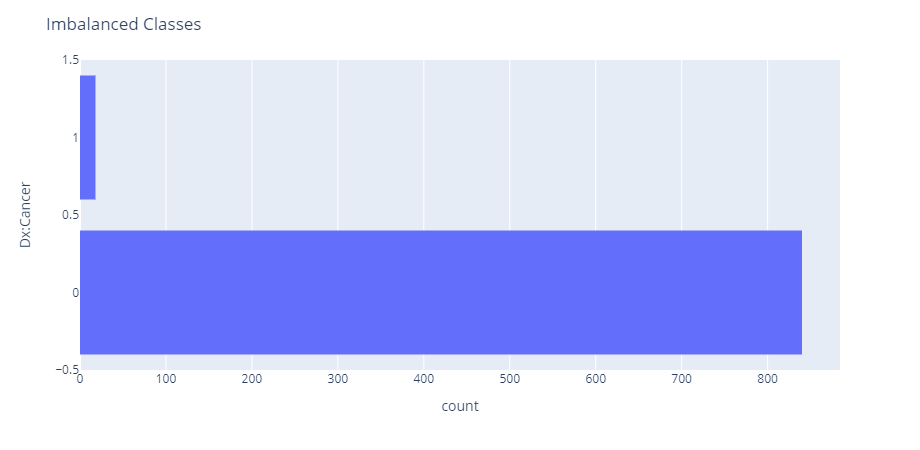

In [32]:
dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Imbalanced Classes")
dx_cancer.show()

In [33]:
X = risk_factor_df.drop(["Dx:Cancer", "age_cat"], axis=1)
y = risk_factor_df["Dx:Cancer"].copy()

In [34]:
# smote = SMOTE(random_state=42)
# x_smote, y_smote = smote.fit_resample(X, y)
# risk_factor_df = x_smote.join(y_smote)
# risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

In [35]:
adasyn = ADASYN(random_state=42)
x_adasyn,y_adasyn = adasyn.fit_resample(X,y)
risk_factor_df = x_adasyn.join(y_adasyn)

In [36]:
# ros = RandomOverSampler(random_state=42)
# x_ros, y_ros = ros.fit_resample(X, y)
# risk_factor_df = x_ros.join(y_ros)

In [37]:
risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

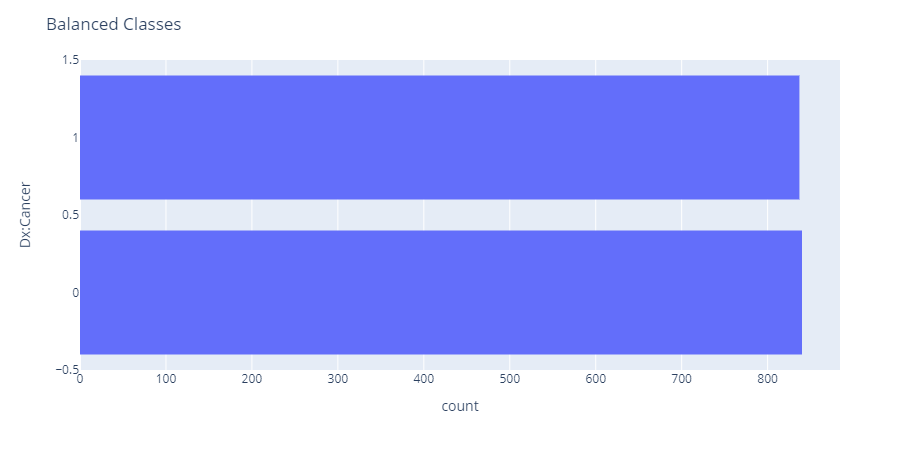

In [38]:
dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
dx_cancer.update_layout(bargap=0.2)
dx_cancer.update_layout(title = "Balanced Classes")
dx_cancer.show()

[](http://)

# Train-Test Split

Data split was stratified on **Age Category**

In [39]:
train_set = None
test_set = None 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(risk_factor_df, risk_factor_df["age_cat"]):
    train_set = risk_factor_df.loc[train_idx]
    test_set = risk_factor_df.loc[test_idx]
cols_to_drop = ["age_cat","total_std","total_tests"]
for set_ in (train_set, test_set):
    for col in cols_to_drop:
        set_.drop(col, axis=1, inplace=True)

In [40]:
X_train = train_set.drop("Dx:Cancer", axis=1)
y_train = train_set["Dx:Cancer"].copy()

X_test = test_set.drop("Dx:Cancer", axis=1)
y_test = test_set["Dx:Cancer"].copy()

# PCA Visualization

We see that 12 out of 35 components explain 99% of the variance of the data. This is means, we can discard the other 23 components, this will signifcantly increase performance. due to a 65% reduction in features.


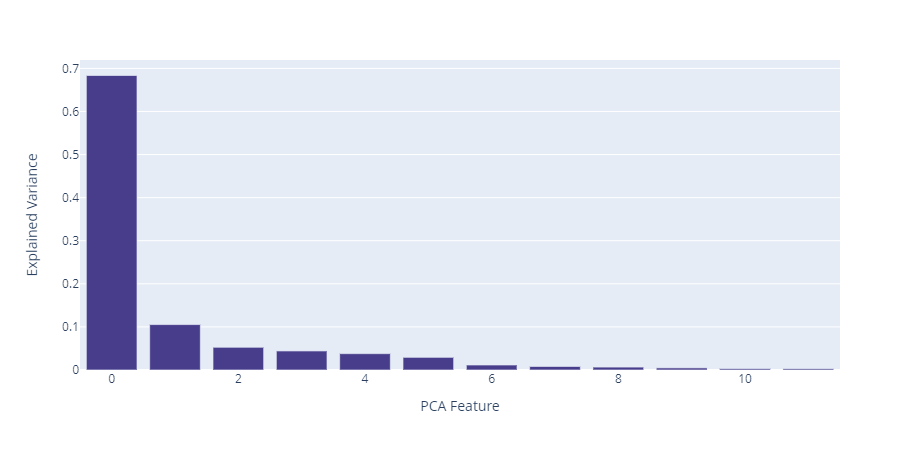

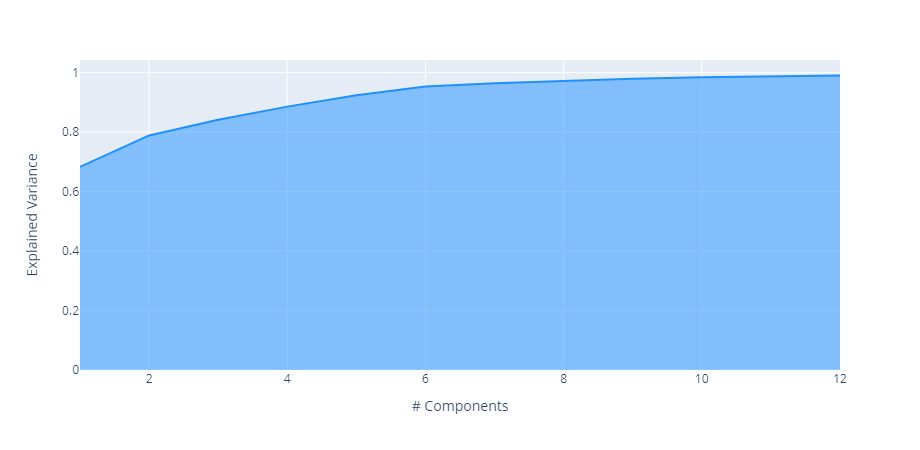

In [41]:
XT = RobustScaler().fit_transform(X_train)
pca = PCA(n_components=0.99)
XT = pca.fit_transform(XT)

dimensions = px.bar(x=range(pca.n_components_), y=pca.explained_variance_ratio_,
                    color_discrete_sequence=["darkslateblue"],
                    labels={"x":"PCA Feature","y":"Explained Variance"})
dimensions.show()
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

explained_variance = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    color_discrete_sequence=["dodgerblue"]
)
explained_variance.show()

# Modelling

In [42]:
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("pca", PCA(n_components=13))
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [43]:
param_grid = {'C': np.logspace(-5, 8, 15)}
logreg = LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid, cv=10,refit=True).fit(X_train,y_train)
logreg_cv = LogisticRegression(**logreg_cv.best_params_)

In [44]:
rnd_clf = RandomForestClassifier(n_estimators=2500, max_leaf_nodes=2, n_jobs=-1,
                                 max_features="sqrt")

In [45]:
knn_clf = KNeighborsClassifier()
knn_param_grid = {"n_neighbors": list(np.arange(1, 100, 2))}
knn_clf_cv = GridSearchCV(knn_clf, knn_param_grid, cv=10,refit=True).fit(X_train,y_train)
knn_clf_cv = KNeighborsClassifier(**knn_clf_cv.best_params_)

In [46]:
svm_clf = SVC()
svc_param_grid = {'C': np.logspace(-3, 2, 6), 'gamma': np.logspace(-3, 2, 6), }
svm_clf_cv = GridSearchCV(svm_clf, svc_param_grid, cv=5)

In [47]:
col_names = ["Classifier Name", "Accuracy Score", "Precision Score",
             "Recall Score", "F1 Score"]
summary_df = pd.DataFrame(columns=col_names)

est_name = []
est_acc = []
precision_score = []
recall_score = []
f1score = []
est_conf_matrix = []

estimators = [
    ("LogisticRegression", logreg_cv),
    ("RandomForestClassifier ", rnd_clf),
    ("KNeighborsClassifier", knn_clf_cv),
    ("SupportVectorClassifier", svm_clf_cv)]

for i in range(0, len(estimators)):
    clf_name = estimators[i][0]
    clf = estimators[i][1]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    # print(pd.crosstab(y_test,y_pred,rownames=["Actual"],colnames=["predicted"],margins=True))
    est_name.append(estimators[i][0])
    est_acc.append(accuracy_score(y_test, y_pred))
    scores = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    precision_score.append(scores[0])
    recall_score.append(scores[1])
    f1score.append(scores[2])
    est_conf_matrix.append(confusion_matrix(y_test,y_pred))


summary_df[col_names[0]] = est_name
summary_df[col_names[1]] = est_acc
summary_df[col_names[2]] = precision_score
summary_df[col_names[3]] = recall_score
summary_df[col_names[4]] = f1score


# Summary

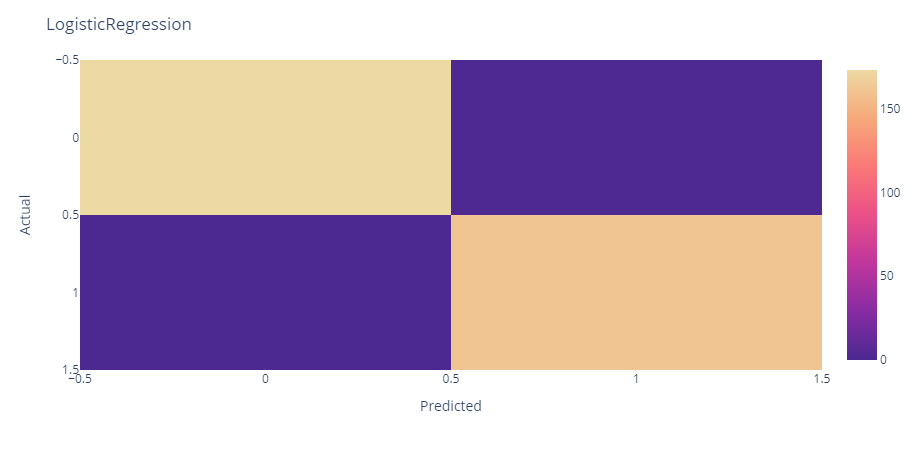

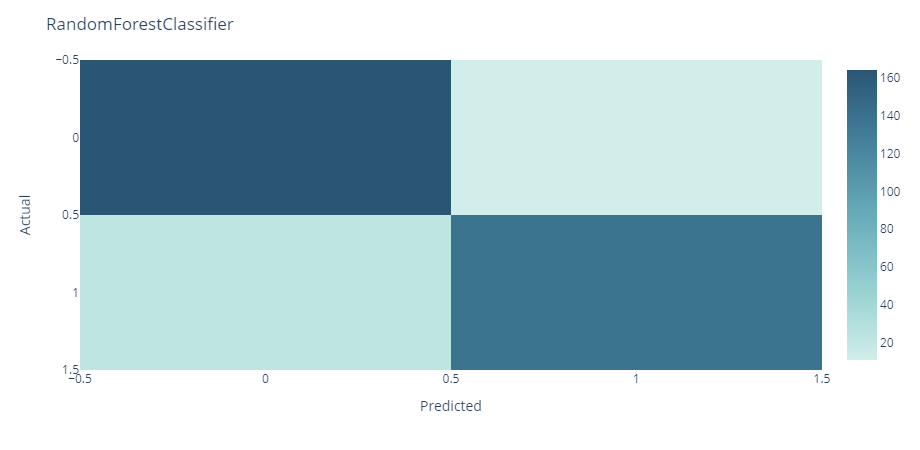

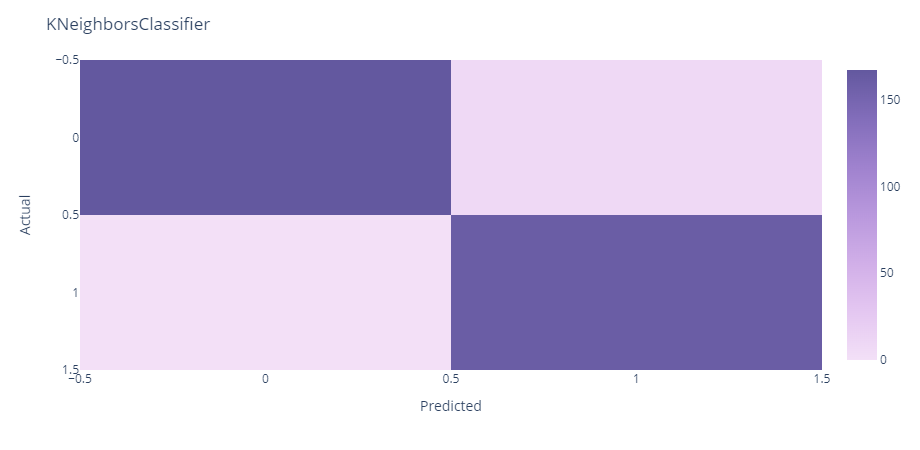

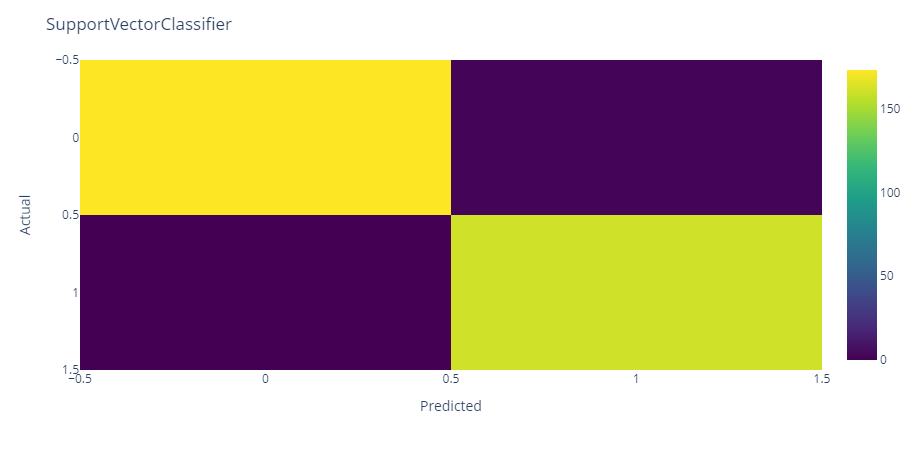

In [48]:
color_scales = ["agsunset","teal","purp","viridis"]
for i in range(0,len(est_conf_matrix)):
    heatmap = px.imshow(est_conf_matrix[i],aspect="auto",
                        text_auto=True,
                        color_continuous_scale=color_scales[i])
    heatmap.update_layout(title = est_name[i])
    heatmap.update_xaxes(title="Predicted")
    heatmap.update_yaxes(title="Actual")
    heatmap.show()

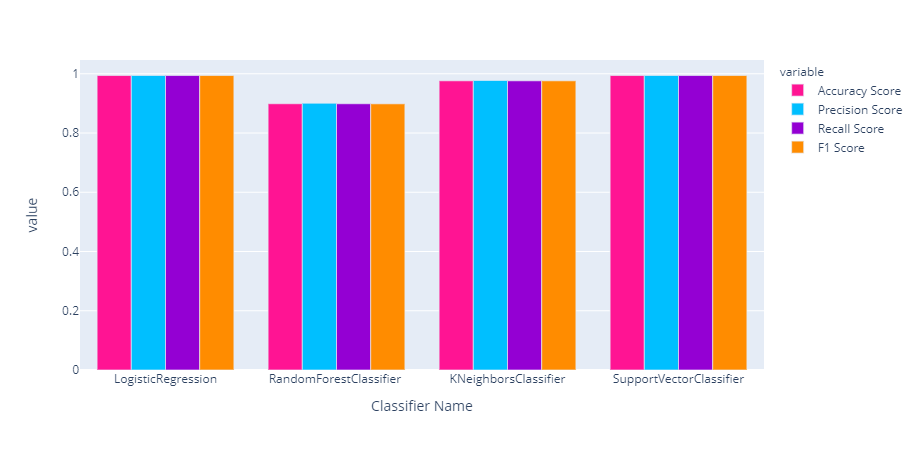

In [49]:
acc_comparison = px.bar(summary_df, x="Classifier Name",
                        y=col_names[1:len(col_names)],
                        color_discrete_sequence=["deeppink",
                                                 "deepskyblue",
                                                 "darkviolet",
                                                 "darkorange"],
                        barmode="group")
acc_comparison.show()

# Interpretation of the results 
* TP: True Positive, these are the values that are positive and were predicted positive 

* FP: False Positive, The values which are negative but were wrongly predicted as positive

* TN: True Negative, these are the values that are negative and were predicted negative 

* FN: False Negative, The values which are positive but were wrongly predicted as negative

## Precision
$$precision = \frac{TP}{TP+FP}$$

This metric measures the actual positive outcomes out of the total predicted positive outcomes. It attempts to identify the proportion of positive identifications that were correct.
The Logistic Regression model and Support Vector Classifer model performed equally well with a precision score of 99.41%. 

In the context of diagnoising cervical cancer, this is metric would not be the most ideal to measure performance, as a negative case being labelled as a positive case is easily solved with confirmatory tests. However, one has to also consider the emotional and mental issues brought upon by being diagnosed with cervical cancer, as this can have a lingering effect even after having confirmatory tests. These tests should be done as soon as possible, as there may be another underlying illness that brought them to see a healthcare professional in the first place. 

## Recall
$$recall = \frac{TP}{TP+FN}$$

This metirc measures the correctly positive predicted outocmes of the total number of positive outcomes. It answers the question of what proportions of actual positives were identified correctly.
The Logistic Regression model and Support Vector Classifer model performed equally well with a recall score of 99.4%. In terms of measuring performance of the model, this is the metric that should be highly considered. 

In the context of diagnosing cervical cancer, we want to reduce the number of false negatives (Actual positive cases labelled as negative cases) as much possible. If an actual positive case is labelled as negative, this has serious consequecnes as the patient would go about their life without actually receiving potentially life saving treatment.

There are many reasons why a cancer can go misdiagnosed, these include:
* The symptoms,especially in the early stages being mistaken for some other type of less serious illness.
* The actual test adminstered by a healthcare professional may give the wrong diagnosis 

The 5-year survival rate tells you what percent of people live at least 5 years after the cancer is found. Percent means how many out of 100. The 5-year survival rate for all people with cervical cancer is 66%. [Source](https://www.cancer.net/cancer-types/cervical-cancer/statistics#:~:text=The%205%2Dyear%20survival%20rate%20tells%20you%20what%20percent%20of%20people%20live%20at%20least%205%20years%20after%20the%20cancer%20is%20found.%20Percent%20means%20how%20many%20out%20of%20100.%20The%205%2Dyear%20survival%20rate%20for%20all%20people%20with%20cervical%20cancer%20is%2066%25)

Survival rates also depend on the stage of cervical cancer that is diagnosed. When detected at an early stage, the 5-year survival rate for people with invasive cervical cancer is 92%. About 44% of people with cervical cancer are diagnosed at an early stage. If cervical cancer has spread to surrounding tissues or organs and/or the regional lymph nodes, the 5-year survival rate is 58%. If the cancer has spread to a distant part of the body, the 5-year survival rate is 18%. [Source](https://www.cancer.net/cancer-types/cervical-cancer/statistics#:~:text=Survival%20rates%20also,rate%20is%2018%25.)

**It is clearly important and evident that a correct diagnosis and early treatment is the best possible way to ensure that a patient has a high chance of surviving.**

## F1 Score 
$$F1 Score = \frac{TP}{TP+\frac{FN+FP}{2}}$$

The F1 score is defined as the harmonic mean of precision and recall. Therefore, a high F1 score means both a high precision and recall, same for low and a medium score if one score is high and the other is low.

The Logistic Regression model and Support Vector Classifer model performed equally well with an accuracy score of 99.4%

## Accuracy 
$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$

The Logistic Regression model and Support Vector Classifer model performed equally well with an accuracy score of 99.4%

